# Clustering

This sections covers the clustering of the data. The goal is to check, whether the data can be clustered to different trip types, customer types, or locations based on the underlying demand patters. Therefore we apply some specific data preparation and apply clustering algorithms, in roder to detect and describe emerging clusters. 

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
# Import of data
df_Trips = pd.read_csv('boston_2017_cleaned_Trips.csv')

# Convert dates to datetime
df_Trips[['start_time','end_time']] = df_Trips[['start_time','end_time']].apply(pd.to_datetime)

In [3]:
df_Trips.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,weekday,duration,month
0,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,MIT at Mass Ave / Amherst St,Dana Park,644,Subscriber,0,6,351.0,1
1,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,Boston Public Library - 700 Boylston St.,B.U. Central - 725 Comm. Ave.,230,Subscriber,0,6,891.0,1
2,2017-01-01 00:16:17,2017-01-01 00:44:10,36,9,Boston Public Library - 700 Boylston St.,Agganis Arena - 925 Comm Ave.,980,Customer,0,6,1673.0,1
3,2017-01-01 00:21:22,2017-01-01 00:33:50,46,19,Christian Science Plaza,Buswell St. at Park Dr.,1834,Subscriber,0,6,748.0,1
4,2017-01-01 00:30:06,2017-01-01 00:40:28,10,8,B.U. Central - 725 Comm. Ave.,Union Square - Brighton Ave. at Cambridge St.,230,Subscriber,0,6,622.0,1


## Data Preparation, Feature Engineering and Scaling

Selection of featues, feature engineering of derived/ calculated features, and finally feature scaling for  clustering

In [4]:
# Create adopted dataset for clustering with desired features
data = df_Trips[['month', 'weekday', 'start_hour', 'user_type', 'duration']].copy()

data.head()

,month,weekday,start_hour,user_type,duration
0,1,6,0,Subscriber,351.0
1,1,6,0,Subscriber,891.0
2,1,6,0,Customer,1673.0
3,1,6,0,Subscriber,748.0
4,1,6,0,Subscriber,622.0


In [5]:
# maybe visualize the utilized data

In [6]:
# Encode user_type to numerical values: 0 = subscriber & 1 = customer
data.loc[data['user_type'] == 'Subscriber', 'user_type'] = 0
data.loc[data['user_type'] == 'Customer', 'user_type'] = 1

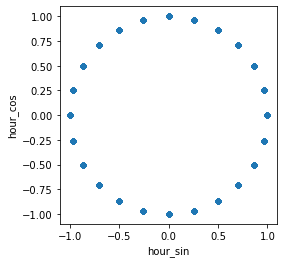

In [7]:
# convert temporal start_hour through sine & cosine transform to cyclical features
# effect: receive a two-dimensional discrete value for the time that connects subsequent cyclical hour values over days

# Transform start_hour values that range from 0 to 23
data['hour_sin'] = np.sin(data['start_hour']*(2.*np.pi/24))
data['hour_cos'] = np.cos(data['start_hour']*(2.*np.pi/24))

# Visualize the cyclical time feature
data.plot.scatter('hour_sin','hour_cos').set_aspect('equal');

In [8]:
# Scaling the whole data to align and standardize the scales of the different features
scaler = StandardScaler()
scaler.fit(data)

data_scaled = scaler.transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns = data.columns, index = data.index)

# Drop unnecessary column start_hour after scaling, because it was substituted by sin & cos values
data_scaled_df = data_scaled_df.drop(['start_hour'], axis = 1)

In [9]:
data_scaled_df.head()

,month,weekday,user_type,duration,hour_sin,hour_cos
0,-2.594193,1.649883,-0.432816,-0.517730,0.315345,2.539249
1,-2.594193,1.649883,-0.432816,-0.005594,0.315345,2.539249
2,-2.594193,1.649883,2.310449,0.736054,0.315345,2.539249
3,-2.594193,1.649883,-0.432816,-0.141216,0.315345,2.539249
4,-2.594193,1.649883,-0.432816,-0.260714,0.315345,2.539249


## Trips Clustering

In the first step, we are going to perform a mainly temporal clustering approach on all trips in the data set.
For that purpose we will consider all time references of each trip (month, weekday, start_hour), as well as the duration of the trip and the user type, to distinguish certain clusters of trip types and users.

First of all, we start with a grid search for an optimum k-value (number of clusters, needed as input parameter for the clustering algorithms) based on the intertia of k-means algorithm to compare different numbers of  clusters. The intertia score helps to evaluate how well a clustering could be peformed on given input data, because it presents an indication for the distance of each data point in a cluster from its' assigned cluster-centroid. Comparing different scores of cluster sizes, using the elbow method, and additionally bringing in some of the already gained insights from the data, we select a good fitting value for k.

After that we apply the actual k-means clustering algorithm to the data set and interpret the determined clusters throguh visualizations.

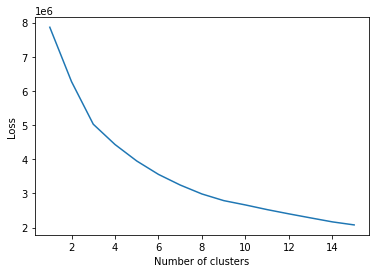

In [65]:
# Grid search to determine an indication for the number of clusters as input parameter for the clustering algorithms

k_max = 15

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1)
    model.fit(data_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# Plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(2.0, 10.0)

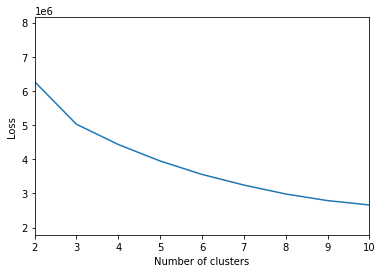

In [72]:
# Zoom in the expected optimum "elbow" value area of the grid search plot

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([2,10])

Based on the grid search, an optimum value for the clustering of this data would lie in range 3 to approximately 6. The clustering with the minimum value k = 3 did not achieve good clustering results. We anyway expected at least 4-5 clusters to capture the data approriately in clusters in oder to distinguish between the characteristics of the desciptive analytics. So we choosed 4 clusters as the next smallest number, that enabled a good fitting clustering.

In [10]:
# Fit model for k = 4 and use k-means++ for initialization
model_km = KMeans(n_clusters = 4, init = 'k-means++', random_state=0)
model_km.fit(data_scaled_df)

# Predict clusters and apply respective cluster name 
numbers = ['zero', 'one', 'two', 'three']
data_scaled_df['cluster'] = model_km.predict(data_scaled_df)
data_scaled_df['cluster'] = data_scaled_df['cluster'].apply(lambda x: numbers[x])

In [11]:
data_scaled_df.head()

,month,weekday,user_type,duration,hour_sin,hour_cos,cluster
0,-2.594193,1.649883,-0.432816,-0.517730,0.315345,2.539249,two
1,-2.594193,1.649883,-0.432816,-0.005594,0.315345,2.539249,two
2,-2.594193,1.649883,2.310449,0.736054,0.315345,2.539249,zero
3,-2.594193,1.649883,-0.432816,-0.141216,0.315345,2.539249,two
4,-2.594193,1.649883,-0.432816,-0.260714,0.315345,2.539249,two


In [12]:
# Join required unscaled features for visualization and interpretation purposes
data_joined = data_scaled_df.join(data[['month', 'weekday', 'start_hour', 'user_type', 'duration']], lsuffix='_scaled', rsuffix='_unscaled')

# Change user_type dtype to numeric for visualization
data_joined['user_type_unscaled'] = data_joined['user_type_unscaled'].apply(pd.to_numeric)

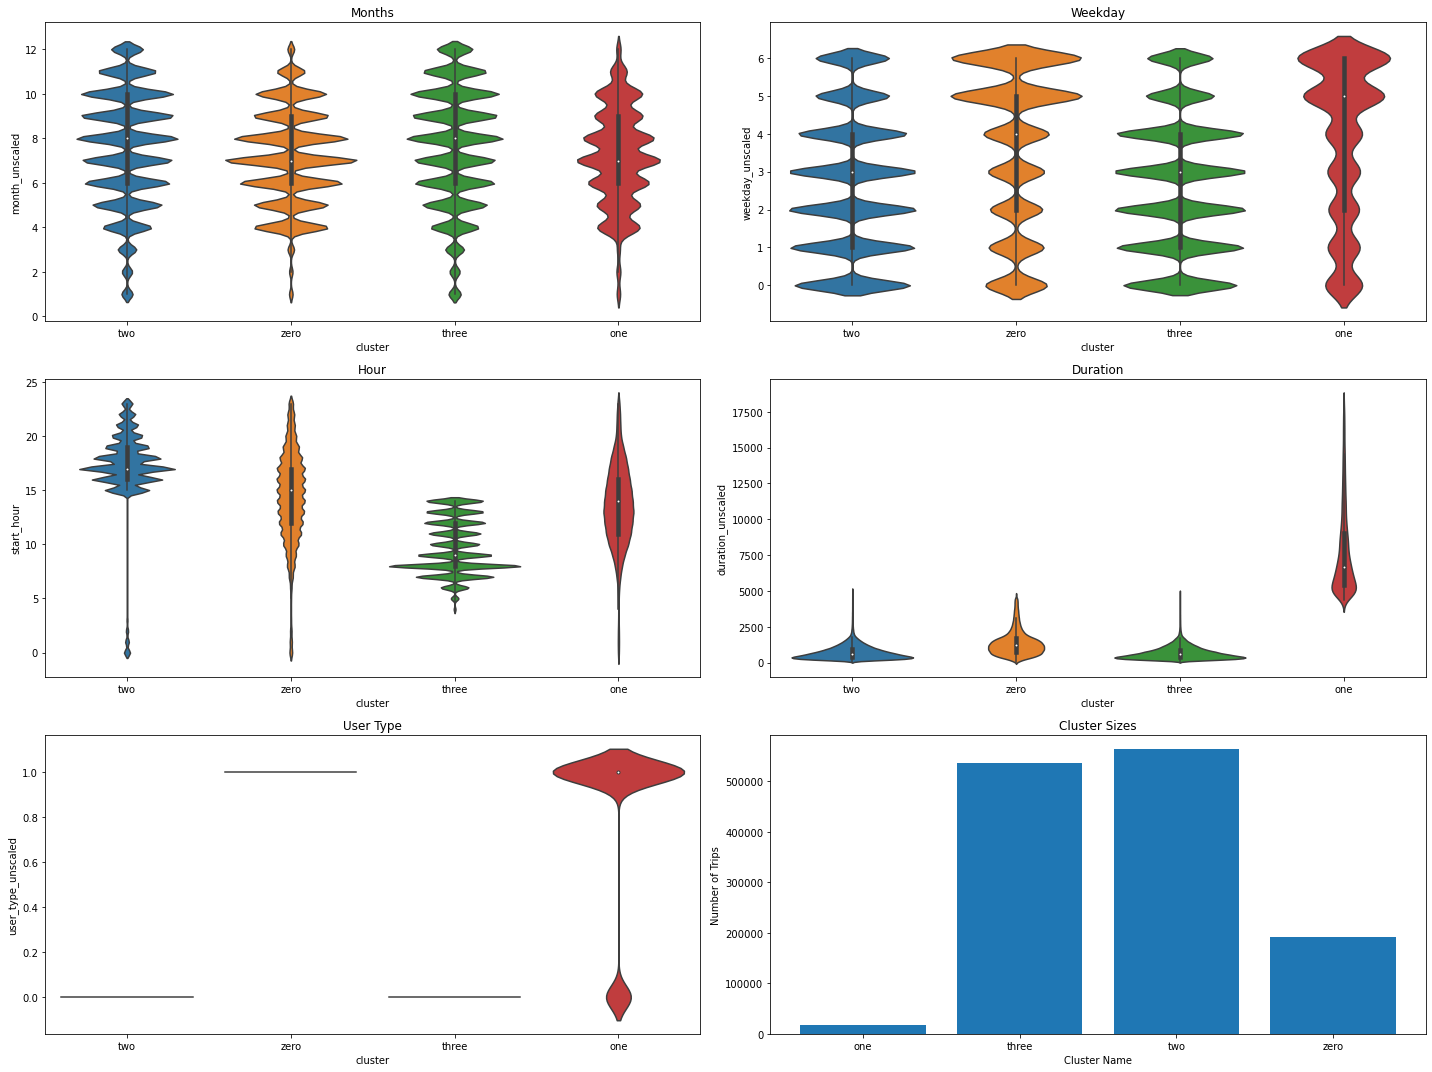

In [14]:
# Create violinplots for each of the features that were included in clustering to interpret the different proposed clusters
# Additionally the cluster sizes are visualized as bar plot
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=data_joined['cluster'], y=data_joined['month_unscaled'], data=data_joined)
axes[0, 0].set_title('Months')

sns.violinplot(ax = axes[0, 1], x=data_joined['cluster'], y=data_joined['weekday_unscaled'], data=data_joined)
axes[0, 1].set_title('Weekday')

sns.violinplot(ax = axes[1, 0], x=data_joined['cluster'], y=data_joined['start_hour'], data=data_joined)
axes[1, 0].set_title('Hour')

sns.violinplot(ax = axes[1, 1], x=data_joined['cluster'], y=data_joined['duration_unscaled'], data=data_joined)
axes[1, 1].set_title('Duration')

sns.violinplot(ax = axes[2, 0], x=data_joined['cluster'], y=data_joined['user_type_unscaled'], data=data_joined)
axes[2, 0].set_title('User Type')

## Delete the 6th subplot because it is not required due to only 5 features
#axes[2, 1].axis('off')

# bar plot of cluster sizes: determined  by aggregation on cluster-name
cluster_size = data_joined.groupby(['cluster'])['cluster'].agg('count')

axes[2, 1].bar(cluster_size.index, cluster_size)
axes[2, 1].set_xlabel('Cluster Name')
axes[2, 1].set_ylabel('Number of Trips')
axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()

The violine plots offer a good interpretation possibility of the value range and density for each of the involved attributes. In combination with the bar plot of the clusters sizes, we can now interpret the clusters.

The following clusters emerged from the k-means algorithm:
- **Cluster zero** = customer cluster: contains only customer users, that preferably took trips from spring to autumn with clear peak in summer. Most number of trips were taken on weekends between morning and 20 o'clock with peak around noon and afternoon, with just a few during night and small number during the week. The duration of these trips ranged from some short ones, to a larger number of medium short trips compared to the other clusters, which indicates that these customer take longer or slower trips (probably for tourists/sightseeing or recreational activities on the weekend)
- **Cluster one** = long trips: consists of some subsriber, but mostly customer users. This cluster has the clearest density in the summer months and most of the trips were also taken around noon and afternoon on weekends. Just very few trips at night and during the week. Main characteristic is the long duration: this cluster includes all very long trips (which are likely carried out in free-time or for touristic purposes)
- **Cluster zero and one** include only very few trips, which is related to the low total number of customer trip and low number of long trips in general
- **Cluster two and three** are quite similar: they both contain the very most of all trips which are carried out by subscribers exclusively. They also show a higher demand in spring, summer,and autumn, but compared to the other cluster they have a more even distribution over the year (=also some usages in winter). This indicates are more regular and constant demand in this clusters, which in combination with the subscirber user type could be applied to the working/ studying group of people. Also, the demand in these clusters is higher during the week as on weekends, which also supports the working/ studying assumption. The trips were very short compared to the other clusters, so that they were likely used for a specific purpose like to get quickly from A to B (within the city center).
- **Cluster two** = night trips and afternoon office hours peak: the distinction of cluster two from three is based on the start hours. This clusters includes all the few short subscriber trips during night and late evening, as well as the peak hour trips in the afternoon that are probably taken after work/ studying/ school to get from the center to somewhere else
- **Cluster three** = morning office hours and lunch time: this cluster contains all the subsriber trips of the morning peak, esepcially around 9/ 10 o'clock. Besides that, also trips around lunch time are included. So probably this cluster contains all the trips there were used to get to work/ university, and also around between those central places


These clusters also fit the findings and expectations from the descriptive analytics very good. Therefore we evaluate these clusters as fitting and k = 4 a good value for this clustering problem.

In the following sections, we provide more specific clustering use-cases that investigate the clustering problem from other angles and approaches.

## Station Clustering

In the next step we perform a clustering of all stations in the data set. The goal is to analyze, whether there are stations that can be clustered on their demand patterns...

In [90]:
# Add a column named start_weekday to the trips dataframe that says if the start_day is a weekday or a weekend.
weekday_lst = [0, 1, 2, 3, 4]
df_Trips['start_weekday'] = ['weekday' if x in weekday_lst else 'weekend' for x in df_Trips['weekday']]

# Create trips_weekday dataframe with only the weekdays by removing all weekend days
trips_weekday = df_Trips[~df_Trips.start_weekday.str.contains("weekend")]
trips_weekday.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,weekday,duration,month,start_weekday
481,2017-01-02 00:01:29,2017-01-02 00:10:30,177,74,University Park,Harvard Square at Mass Ave/ Dunster,1879,Subscriber,0,0,541.0,1,weekday
482,2017-01-02 00:06:28,2017-01-02 00:09:24,95,78,Cambridge St - at Columbia St / Webster Ave,Union Square - Somerville,901,Subscriber,0,0,176.0,1,weekday
483,2017-01-02 00:08:11,2017-01-02 00:12:12,19,33,Buswell St. at Park Dr.,Kenmore Sq / Comm Ave,17,Subscriber,0,0,241.0,1,weekday
484,2017-01-02 00:08:44,2017-01-02 00:12:06,19,33,Buswell St. at Park Dr.,Kenmore Sq / Comm Ave,103,Subscriber,0,0,202.0,1,weekday
485,2017-01-02 00:17:24,2017-01-02 00:50:12,36,20,Boston Public Library - 700 Boylston St.,Aquarium Station - 200 Atlantic Ave.,1062,Subscriber,0,0,1968.0,1,weekday


In [91]:
# Group by start_hour and start_station_number and count the number of trips
trips_station = trips_weekday.groupby(["start_hour","start_station_id"]).count()

# Use unstack() in order to be able to plot the total number of trips by hour as a function of the day for two years
trips_station = trips_station['duration'].unstack()
trips_station.isna().sum()
trips_station = trips_station.fillna(0)

trips_station.head()

start_station_id,1,3,4,5,6,7,8,9,10,11,...,221,222,224,225,226,227,228,229,230,232
start_hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,19.0,72.0,58.0,36.0,20.0,26.0,37.0,60.0,39.0,...,32.0,1.0,2.0,4.0,17.0,33.0,3.0,0.0,0.0,0.0
1,0.0,4.0,30.0,21.0,21.0,3.0,13.0,18.0,32.0,21.0,...,14.0,0.0,1.0,7.0,8.0,15.0,2.0,0.0,0.0,0.0
2,0.0,0.0,18.0,10.0,5.0,0.0,8.0,12.0,14.0,9.0,...,4.0,1.0,3.0,4.0,6.0,10.0,0.0,0.0,0.0,0.0
3,0.0,5.0,3.0,4.0,5.0,0.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0
4,0.0,4.0,5.0,5.0,11.0,0.0,11.0,9.0,18.0,6.0,...,1.0,0.0,0.0,3.0,4.0,6.0,0.0,0.0,0.0,0.0


In [92]:
# Normalize the time series for all stations using the apply method.
trips_station_normal = trips_station.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis=0)
trips_station_normal.head()

start_station_id,1,3,4,5,6,7,8,9,10,11,...,221,222,224,225,226,227,228,229,230,232
start_hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.024235,0.073482,0.088962,0.029693,0.022727,0.033189,0.049088,0.064591,0.030810,...,0.159204,0.010989,0.032258,0.005682,0.026915,0.048137,0.007812,0.0,0.0,0.0
1,0.0,0.005102,0.028754,0.028007,0.015326,0.003409,0.014430,0.022440,0.032295,0.014965,...,0.069652,0.000000,0.016129,0.014205,0.008282,0.020186,0.005208,0.0,0.0,0.0
2,0.0,0.000000,0.015974,0.009885,0.000000,0.000000,0.007215,0.014025,0.011534,0.004401,...,0.019900,0.010989,0.048387,0.005682,0.004141,0.012422,0.000000,0.0,0.0,0.0
3,0.0,0.006378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002070,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.005102,0.002130,0.001647,0.005747,0.000000,0.011544,0.009818,0.016148,0.001761,...,0.004975,0.000000,0.000000,0.002841,0.000000,0.006211,0.000000,0.0,0.0,0.0


In [93]:
# Transpose the dataframe in order to be able to apply the k-means model on each bike station.
trips_station_normal_trans = trips_station_normal.transpose()

# Transform the trips_station_normal_trans dataframe to an array in order to be able to use k-means method
X = trips_station_normal_trans.to_numpy()

In [94]:
# Fit the kmeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# See the label array and assign it to a variable called label
kmeans.labels_

array([1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1,
       1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2,
       2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 0, 2,
       0, 2, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2,
       2, 2, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 2, 0, 1, 1, 0,
       1, 0])

In [95]:
# Add the label array to the trips_station_normal_trans array
array_cluster = np.column_stack((trips_station_normal_trans,kmeans.labels_))

# Transform the array into a dataframe
trips_station_normal_trans = pd.DataFrame(array_cluster)

# Transpose the dataframe to have the cluster number for each station in the dataframe
trips_station_normal_cluster = trips_station_normal_trans.transpose()
trips_station_normal_cluster.tail()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
20,0.0,0.179847,0.241747,0.599671,0.302682,0.136364,0.124098,0.474053,0.433679,0.189261,...,0.437811,0.142857,0.516129,0.238636,0.213251,0.309006,0.070312,0.0,0.0,1.0
21,0.0,0.123724,0.221512,0.477759,0.198276,0.084091,0.093795,0.388499,0.298731,0.132042,...,0.636816,0.043956,0.193548,0.156250,0.184265,0.197205,0.044271,0.0,0.0,0.0
22,0.0,0.100765,0.190628,0.253707,0.177203,0.053409,0.082251,0.225806,0.214533,0.111796,...,0.398010,0.010989,0.000000,0.130682,0.120083,0.166149,0.028646,0.0,0.0,0.0
23,0.0,0.058673,0.139510,0.181219,0.113985,0.040909,0.054834,0.161290,0.138408,0.088028,...,0.318408,0.054945,0.032258,0.073864,0.076605,0.118012,0.031250,0.0,0.0,0.0
24,1.0,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,1.000000,1.000000,...,2.000000,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.0,1.0,0.0


In [96]:
# Select the stations that are part of cluster 0 (i.e. that have index 24 = 0)
trips_station_normal_cluster0 = trips_station_normal_cluster[trips_station_normal_cluster.columns[trips_station_normal_cluster.iloc[-1]==0.000000]]
# Select the stations that are part of cluster 1 (i.e. that have index 24 = 1)
trips_station_normal_cluster1 = trips_station_normal_cluster[trips_station_normal_cluster.columns[trips_station_normal_cluster.iloc[-1]==1.000000]]
# Select the stations that are part of cluster 2 (i.e. that have index 24 = 2)
trips_station_normal_cluster2 = trips_station_normal_cluster[trips_station_normal_cluster.columns[trips_station_normal_cluster.iloc[-1]==2.000000]]

In [97]:
# Remove the last row of the previous dataframe
trips_station_normal_cluster0 = trips_station_normal_cluster0.drop([24])
# Remove the last row of the previous dataframe
trips_station_normal_cluster1 = trips_station_normal_cluster1.drop([24])
# Remove the last row of the previous dataframe
trips_station_normal_cluster2 = trips_station_normal_cluster2.drop([24])

In [98]:
# Add a column that gives the average of all previous columns
trips_station_normal_cluster0['average'] = trips_station_normal_cluster0.mean(numeric_only=True, axis=1)
# Add a column that gives the average of all previous columns
trips_station_normal_cluster1['average'] = trips_station_normal_cluster1.mean(numeric_only=True, axis=1)
# Add a column that gives the average of all previous columns
trips_station_normal_cluster2['average'] = trips_station_normal_cluster2.mean(numeric_only=True, axis=1)

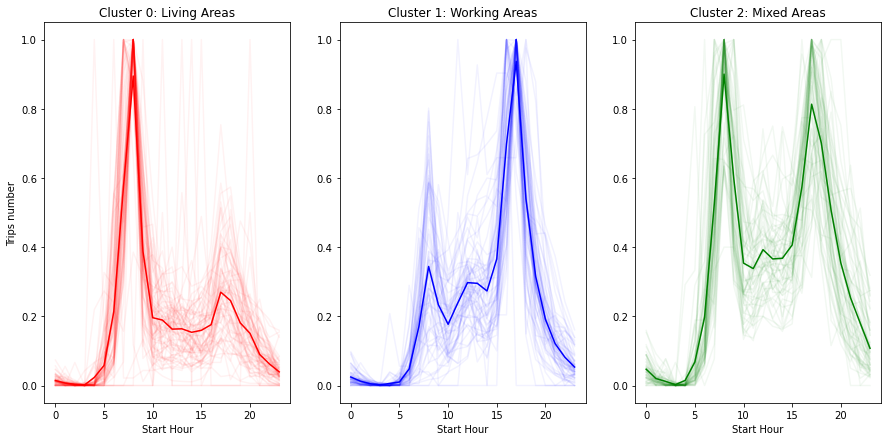

In [122]:
# Plot all the normalised curves and the average for each cluster
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,7))

# Plot Cluster 0
trips_station_normal_cluster0.plot(ax=ax[0],color='red', alpha=0.05)
trips_station_normal_cluster0["average"].plot(ax=ax[0],color='red', alpha=1)
ax[0].get_legend().remove()
ax[0].set_title('Cluster 0: Living Areas')
ax[0].set_ylabel('Trips number')
ax[0].set_xlabel('Start Hour')

# PLot Cluster 1 
trips_station_normal_cluster1.plot(ax=ax[1],color='blue', alpha=0.05)
trips_station_normal_cluster1["average"].plot(ax=ax[1],color='blue', alpha=1)
ax[1].get_legend().remove()
ax[1].set_title('Cluster 1: Working Areas')
ax[1].set_xlabel('Start Hour')

# PLot Cluster 2
trips_station_normal_cluster2.plot(ax=ax[2],color='green', alpha=0.05)
trips_station_normal_cluster2["average"].plot(ax=ax[2],color='green', alpha=1)
ax[2].get_legend().remove()
ax[2].set_title('Cluster 2: Mixed Areas')
ax[2].set_xlabel('Start Hour')

plt.show()

## Extended Trip Clustering (?)

Ricardas clustering mit Wetter